In [1]:
import warnings
warnings.filterwarnings('ignore')

# Lab 10 - Linear Models - Solution

In [2]:
%matplotlib inline

## Directions

**Failure to follow the directions will result in a "0"**

The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN605.448@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

### General Instructions

1.  You will be submitting your assignment to Blackboard. If there are no accompanying files, you should submit *only* your notebook and it should be named using *only* your JHED id: fsmith79.ipynb for example if your JHED id were "fsmith79". If the assignment requires additional files, you should name the *folder/directory* your JHED id and put all items in that folder/directory, ZIP it up (only ZIP...no other compression), and submit it to Blackboard.
    
    * do **not** use absolute paths in your notebooks. All resources should appear in the same directory as the rest of your assignments.
    * the directory **must** be named your JHED id and **only** your JHED id.
    
2. Data Science is as much about what you write (communicating) as the code you execute (researching). In many places, you will be required to execute code and discuss both the purpose and the result. Additionally, Data Science is about reproducibility and transparency. This includes good communication with your team and possibly with yourself. Therefore, you must show **all** work.

3. Avail yourself of the Markdown/Codecell nature of the notebook. If you don't know about Markdown, look it up. Your notebooks should not look like ransom notes. Don't make everything bold. Clearly indicate what question you are answering.

4. Submit a cleanly executed notebook. It should say `In [1]` for the first codecell and increase by 1 throughout.

## Linear Regression

In a previous module (Lab 5), you performed EDA on the insurance data set. In this Lab, you should build a linear regression model trying to estimate `charges`.

In [3]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

sns.set(style="whitegrid")

# Answer

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <ol>
        <li>We don't expect you to get these exact results. We expect you to follow the exact process we described in <em>Fundamentals</em>, exactly.</li>
        <li>The normal progression would be EDA (Module 5), Null/Distributional Model (Module 6), then Linear Model (Module 9-10). You didn't need to bring everything back together but you should try to do so for your own practice.</li>
        <li>We use statistical inference (Module 7) to help us build the model, but we tend not to define individual ROPEs for each coefficient. We're generally interested in the <em>sign</em> of the coefficient. However, do not be mislead into thinking that credible intervals are the same as confidence intervals. For a confidence interval, it <strong>cannot</strong> matter where 0 is in the interval, because it is <em>just</em> an interval. Credible intervals, on the other hands, are summaries of posterior distributions...it <em>may</em> matter where 0 is in the interval.</li>
    </ol>
</div>

We'll start by loading the data:

In [5]:
insurance = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/insurance.csv", header=0)

In [5]:
!head insurance.csv

age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.924
18,male,33.77,1,no,southeast,1725.5523
28,male,33,3,no,southeast,4449.462
33,male,22.705,0,no,northwest,21984.47061
32,male,28.88,0,no,northwest,3866.8552
31,female,25.74,0,no,southeast,3756.6216
46,female,33.44,1,no,southeast,8240.5896
37,female,27.74,3,no,northwest,7281.5056
37,male,29.83,2,no,northeast,6406.4107


In [6]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The data contains a number of variables. 
We have age, sex, BMI, number of children, smoking, region, and the target variable, charges.
There are no null values.

Let's review the histogram for `charges`.
We noted in our EDA that `charges` is not normally distributed ("the normal distribution is not a good model for this data").
This is *not* a problem for Linear Regression when using Bootstrapping.

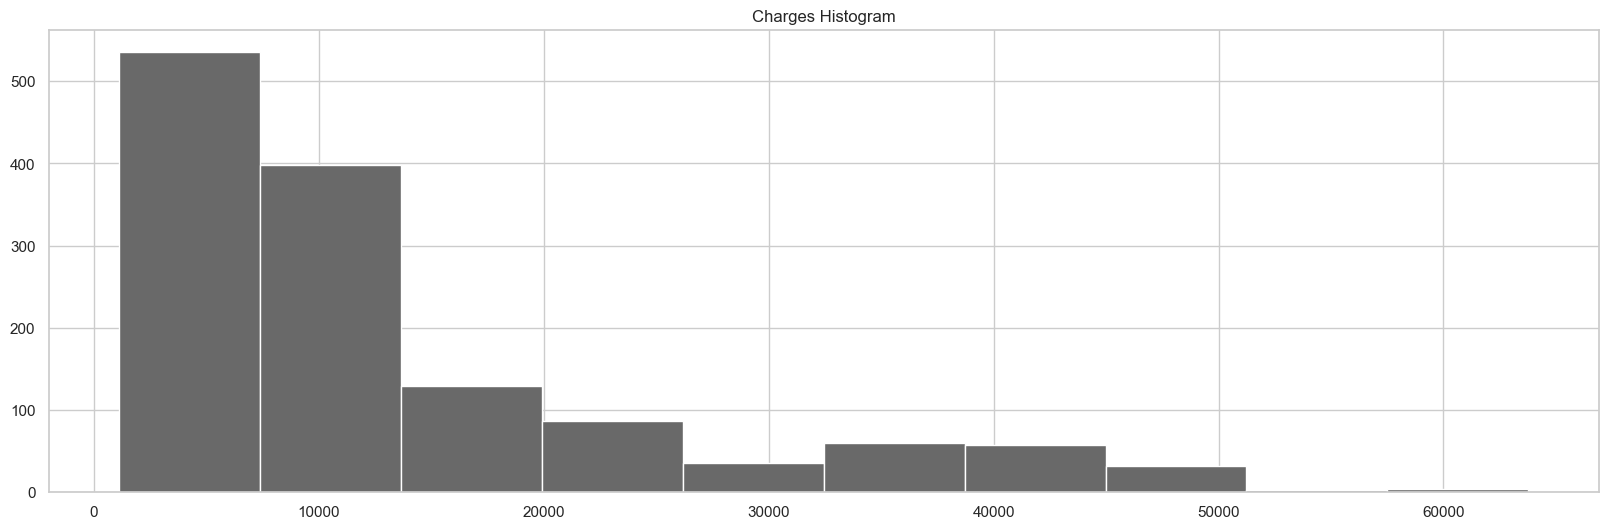

In [7]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(insurance.charges, color='dimgray')
axes.set_title("Charges Histogram")
plt.show()
plt.close()    

Let's review the EDA from Lab 5. What did we learn?

* Age - Numerical variable, weak to moderate + correlation with charges.
* Sex - Categorical variable, unordered. charges are higher for men than women, as reported.
* BMI - Numerical variable, weak + correlation with charges.
* Children - Numerical variable, count, very weak + correlation with charges.
* Smoking - Categorical variable, unordered. 
* Region - Categorical variable, unordered. Definitions unknown, however there are higher average charges associated with the Southeast.
* Charges - Numerical variable, target.

For the features, there's nothing that particularly stands out as needing our attention. Sex and smoker will need to be converted into a dummy variable and Region will need to be converted into four dummy variables.

In [7]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)

In [9]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges,female,male,northeast,northwest,southeast,southwest,smoke_no,smoke_yes
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,0,0,1,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0,0,1,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0,0,1,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0,1,0,0,1,0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0,1,0,0,1,0


Let's reproduce our correlation coefficients from Lab 5's EDA.
<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>When doing EDA, correlation coefficients are merely descriptive statistics.</p>
    <p>When doing <em>linear regression modeling</em>, we also need correlation coefficients to diagnose potential problems. This doesn't magically add domain knowledge or causal understanding for all the reasons we've discussed. This point will become obvious in a bit...</p>
</div>

Since we've decided to use a linear model, it is a bit more important to look at the correlation coefficients between each variable and the target, and each other:

In [10]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [11]:
correlations(insurance, "charges", ["age", "male", "female", 
                                    "bmi", "smoke_yes", "children", 
                                    "northwest", "southwest", "southeast"])

,feature,r,rho
0,age,0.299008,0.534392
1,male,0.057292,0.009490
2,female,-0.057292,-0.009490
3,bmi,0.198341,0.119396
4,smoke_yes,0.787251,0.663460
5,children,0.067998,0.133339
6,northwest,-0.039905,-0.021634
7,southwest,-0.043210,-0.042354
8,southeast,0.073982,0.017275


There are some interesting results here:

1. age - as we saw in the EDA, there is a positive relationship (30%) but that Spearman's suggests that the relationship is non-linear.
2. male - not a huge relationship.
3. female - exact same but opposite relationship as `male`. I included it to demonstrate why it's not needed to include both. I'm including the `sex` dummy variable for `male` because our EDA suggested that there was some relationship there.
4. bmi - not a huge relationship and the Spearman doesn't suggest that this is because it's nonlinear.
5. smoking - definite relationship. We already knew this.
6. children - not a huge relationship but the larger Spearman's indicates the relationship might be non-linear.

The `southeast` variable looks at least as promising as `male` but we'll hold off on the regional variables for now. There's good reason to believe that for any effect we find, it's likely that regional differences are the result of the different distributions of those effects.

Before estimating any linear models, let's look at the Null model (the mean):

In [12]:
insurance.charges.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

The lowest charge is \\$1,121 and the highest is \\$63,770. The mean is \\$13,270 with a standard deviation of \\$12,110. You can think of \\$12,110 as the $\sigma$ of the Null model.

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>But why can't we get error bounds from the standard deviation?</p>
</div>

This is what we're trying to beat by creating a linear regression model (of course, we may also be interested in explanation as well).

The best place to start, in general, is the "all in" model. 
We have domain knowledge and some statistics to support the inclusion of all the variables (exception regions). 
The theory of feature bundles suggests that subtractive modeling (removing variables) is better than additive modeling (adding variables one at a time).

In [8]:
import models

In [9]:
model = "charges ~ age + male + bmi + smoke_yes + children + northwest + southeast + southwest"
result1 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-11938.54,-13691.13,-9733.63
age,$\beta_{1}$,-131.31,-793.44,439.89
male,$\beta_{2}$,23848.53,22791.93,24671.06
bmi,$\beta_{3}$,-352.96,-1147.28,471.33
smoke_yes,$\beta_{4}$,-1035.02,-1925.15,-113.45
children,$\beta_{5}$,-960.05,-1749.82,-92.67
northwest,$\beta_{6}$,256.86,231.45,273.97
southeast,$\beta_{7}$,339.19,271.89,391.12
southwest,$\beta_{8}$,475.50,188.51,706.50


The coefficient of determination ($R^2$) is 75% which is pretty good.
The error ($\sigma$) has been cut in half compared to the Null model (\\$12,110) to \\$6,070.

What does the model say?
Let's ignore the intercept for now, it's not particularly interesting because there are no childless, non-smoking females with no age and no BMI!

* age - every year of age adds \\$257 to charges.
* male - if the patient is male, subtract \\$131 from charges.
* bmi - for every point of BMI, add \\$339 to charges.
* smoke_yes - add \\$23,849 to charges.
* children - for every child, add \\$475 to charges.
* if the patient lives in the northwest, subtract \\$353 from charges.
* if the patient lives in the southeast, subtract \\$1,035 from charges.
* if the patient lives in the southwest, subtract \\$960 from charges.

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>Notice how the signs and effect sizes change from the correlation coefficients to the linear model coefficients. Why? The linear regression isolates (to a certain degree) effects, specifically, variation attributable to the specific variables. If we originally thought that being male raised charges, it could simply be because more men smoked and that it's the smoking increased charges.</p>
    <p>This is one of the reasons that <em>starting</em> with correlation coefficients is nearly useless. And it's worse if you aren't going to use a linear model because correlation and, Gini coefficients in a Decision Tree don't necessarily track.</p>
</div>

How can we improve the model?
Gelman gave us a decision table based on domain knowledge, the sign, and the credible interval of the coefficient.

| coefficient |     value | expected | credible | decision |
|-------------|----------:|----------|----------|----------|
| age         |    256.86 | yes      | yes      | keep     |
| male        |   -131.31 | no       | no       | remove   |
| bmi         |    339.19 | yes      | yes      | keep     |
| smoke_yes   |  23848.53 | yes      | yes      | keep     |
| children    |    475.50 | yes      | yes      | keep     |
| northwest   |   -352.96 | yes      | no       | keep     |
| southeast   | -1,035.02 | no       | yes      | examine  |
| southwest   |   -960.05 | yes      | yes      | keep     |

We can also look for patterns in the residuals (but we do not care if they are normally distributed!):

In [10]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    variables = ["age", "bmi", "children"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(insurance[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

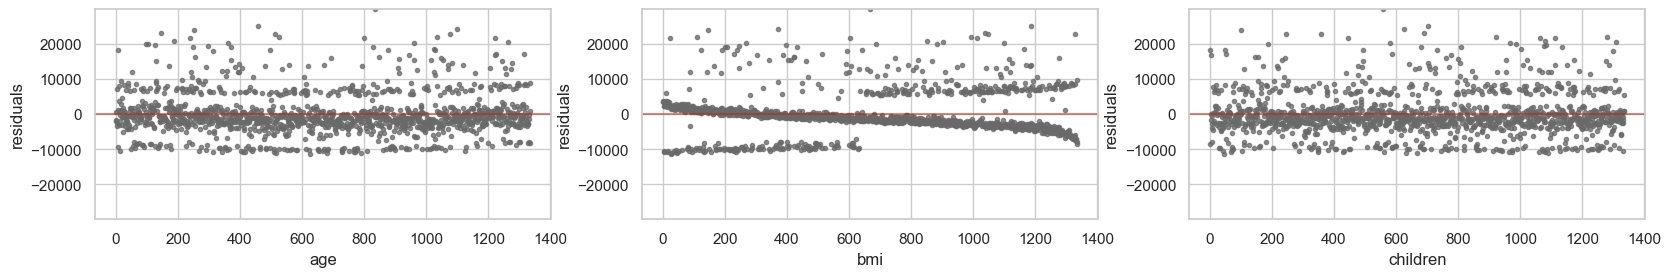

In [16]:
residuals1 = plot_residuals(result1, ["age", "bmi", "children"])

For age, we see three bands. We saw these bands in our EDA. They basically say, at every age, there is some information you are missing that is causing you to be systematically wrong. But they are also slightly curved in a way that suggests increasing returns just like in our discussion of residuals. Additionally, the errors are not symmetric. For every age, we are more likely to overestimate charges.

We see the same banding for children and the same systematic over estimation.

The most interesting result is for BMI. First, the middle band has an inflection that suggests a non-linearity. Second, there's an abrupt break in the error just over the 600th observation. Additionally, if you connected the those two lines, it suggests that you'd have the opposite inflection as the middle line.

Let's start with the revised model, based on the credible intervals.
We will only remove `male`.
We'll leave `southeast` for now as we didn't have strong opinions about its value; the EDA just suggested it would be positive.

In [17]:
model = "charges ~ age + bmi + smoke_yes + children + northwest + southeast + southwest"
result2 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result2)

['Intercept', 'age', 'bmi', 'smoke_yes', 'children', 'northwest', 'southeast', 'southwest']


,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
Intercept,$\beta_{0}$,-11990.27,-13958.28,-10063.08
age,$\beta_{1}$,256.97,232.56,276.67
bmi,$\beta_{2}$,338.66,272.94,402.01
smoke_yes,$\beta_{3}$,23836.30,22874.47,25063.42
children,$\beta_{4}$,474.57,283.02,701.73
northwest,$\beta_{5}$,-352.18,-1307.05,597.30
southeast,$\beta_{6}$,-1034.36,-2050.45,-219.03
southwest,$\beta_{7}$,-959.37,-1855.62,-274.56
,,,,


These results are largely what we saw before.
Let's look at the residuals:

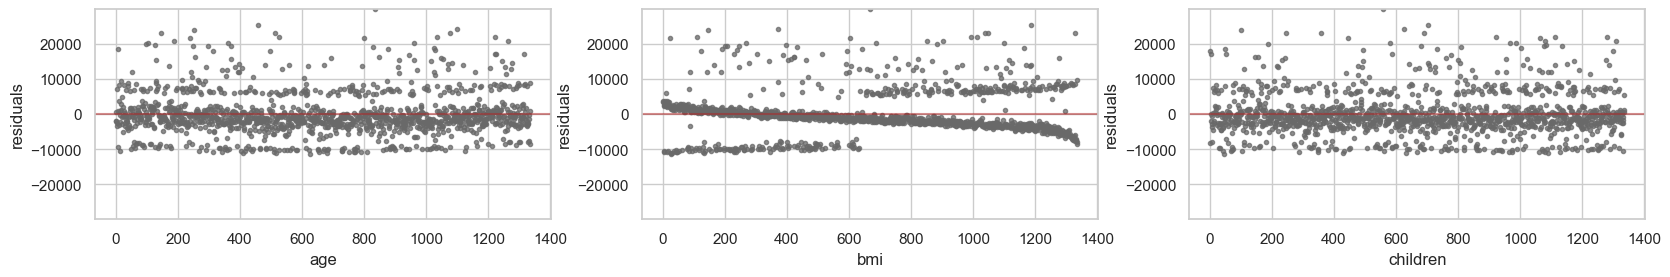

In [18]:
residuals2 = plot_residuals(result2, ["age", "bmi", "children"])

So, the banding is still there...we didn't really do anything that might eliminate it.
There is also a slight curvature associated with the age variable.

For pedagogical purposes, let's compare the histograms of charges and the residuals:

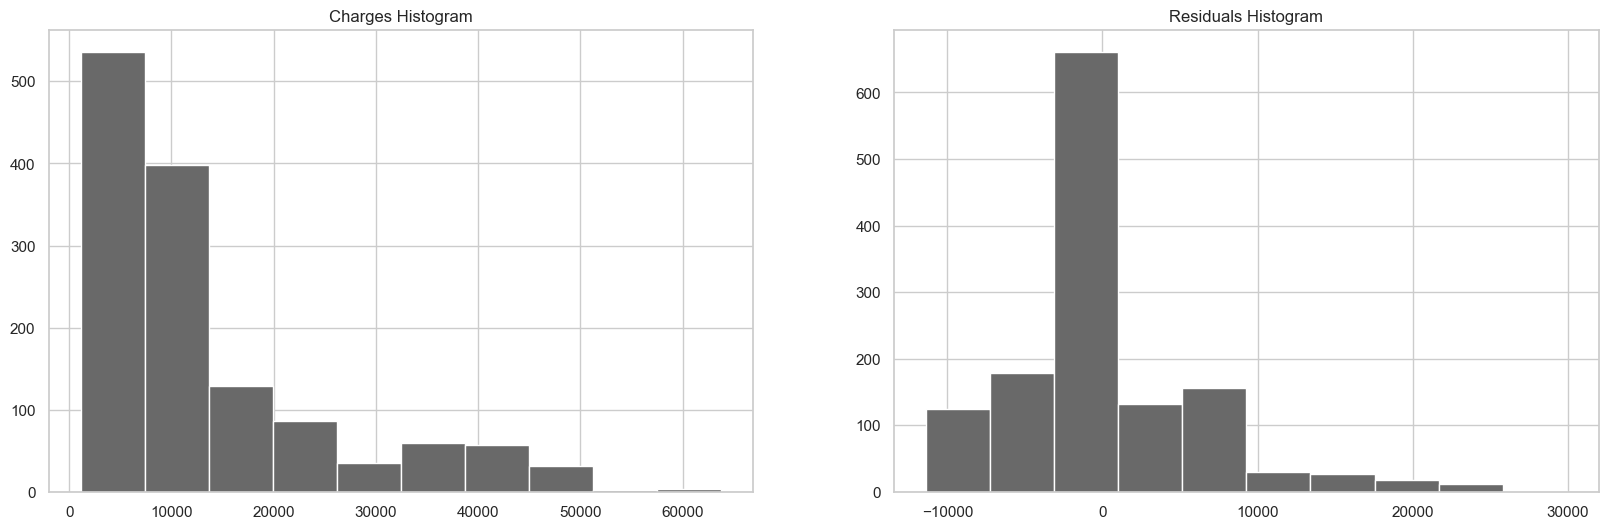

In [19]:
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(insurance.charges, color='dimgray')
axes.set_title("Charges Histogram")

axes = figure.add_subplot(1, 2, 2)
axes.hist(residuals2, color='dimgray')
axes.set_title("Residuals Histogram")

plt.show()
plt.close()    

Note that our errors are much more symmetric with the actual charges variable.

This is a key point that is often misunderstood or even misstated: linear regression does not require your variables to be normally distributed.
Additionally, it does not require that your errors be normally distributed: the regression line will always minimize mean squared error, no other line does.
Normality is only required for Frequentist inference, for the confidence intervals on the coefficients, and because we're using the Bootstrap, we do not need to transform charges.
Additionally, we should not transform charges because a model that predicts log charges isn't the same model as one that predicts charges (and is much, much more difficult to explain).

Unlike many such situations, there are no variables we haven't added to the data so we're left with:

1. transforms
2. interaction terms.

We have some ideas for transforms so let's start there. 
Age looks like it should be squared. 
This basically means that as you age, charges increase *and at an increasing amount*. 
Let's see if that's true:

In [11]:
insurance["age_sq"] = insurance.age**2

In [12]:
model = "charges ~ age_sq + bmi + smoke_yes + children + northwest + southeast + southwest"
result3 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-7600.57,-8793.33,-5741.83
age_sq,$\beta_{1}$,23845.97,22579.04,25041.44
bmi,$\beta_{2}$,-364.28,-1349.47,427.41
smoke_yes,$\beta_{3}$,-1029.72,-2013.97,-131.82
children,$\beta_{4}$,-956.95,-1727.96,-294.16
northwest,$\beta_{5}$,3.26,3.01,3.50
southeast,$\beta_{6}$,335.02,266.10,379.07
southwest,$\beta_{7}$,612.01,395.72,907.03
,,,,


That didn't change the $R^2$ what about the residuals?

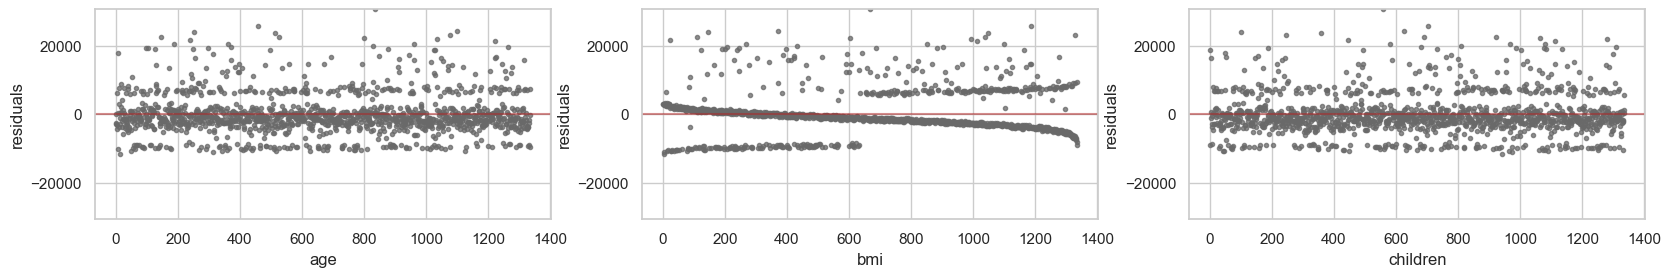

In [22]:
residuals3 = plot_residuals(result3, ["age_sq", "bmi", "children"])

For comparison,

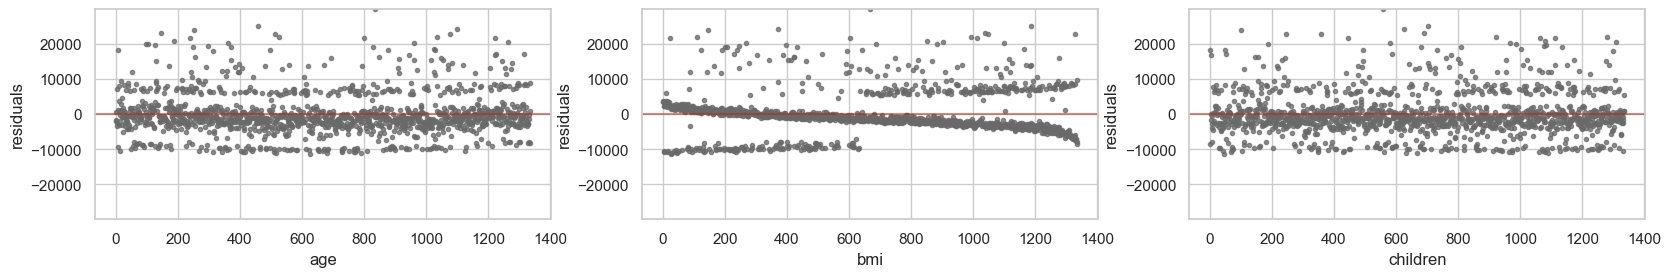

In [23]:
plot_residuals(result1, ["age", "bmi", "children"]); # the semicolon suppresses printing out the result.

So the curves in *age* are gone, the error ($\sigma$) went down *slightly* but the artifacts on BMI are less disperse with the new model. Let's see if we can fix that. 
What if there are *decreasing* returns to BMI, ie, as BMI goes up, charges go up, but at a *decreasing* rate.

In [24]:
insurance["bmi_sqrt"] = insurance.bmi.apply(np.sqrt)

In [25]:
model = "charges ~ age_sq + bmi_sqrt + smoke_yes + children + northwest + southeast + southwest"
result4 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result4)

['Intercept', 'age_sq', 'bmi_sqrt', 'smoke_yes', 'children', 'northwest', 'southeast', 'southwest']


,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
Intercept,$\beta_{0}$,-17853.56,-20833.58,-14248.21
age_sq,$\beta_{1}$,3.25,3.01,3.55
bmi_sqrt,$\beta_{2}$,3729.49,3126.19,4295.67
smoke_yes,$\beta_{3}$,23851.83,22744.69,25016.87
children,$\beta_{4}$,611.98,355.29,838.65
northwest,$\beta_{5}$,-390.03,-1346.45,610.73
southeast,$\beta_{6}$,-1027.51,-2053.24,-113.86
southwest,$\beta_{7}$,-980.14,-1764.90,-102.65
,,,,


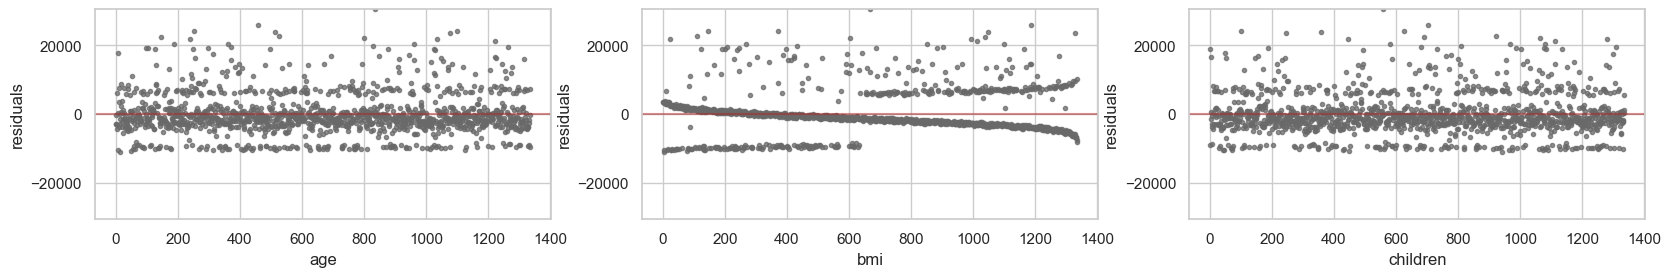

In [26]:
residuals4 = plot_residuals(result4, ["age", "bmi", "children"])

Doesn't look like it...squared?
This would mean, again, that as BMI goes up, charges go up, but at an *increasing* rate:

In [27]:
insurance["bmi_sq"] = insurance.bmi**2

In [28]:
model = "charges ~ age_sq + bmi_sq + smoke_yes + children + northwest + southeast + southwest"
result5 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result5)

['Intercept', 'age_sq', 'bmi_sq', 'smoke_yes', 'children', 'northwest', 'southeast', 'southwest']


,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
Intercept,$\beta_{0}$,-2371.13,-3394.05,-1133.61
age_sq,$\beta_{1}$,3.28,2.89,3.55
bmi_sq,$\beta_{2}$,5.09,3.97,5.98
smoke_yes,$\beta_{3}$,23833.27,22520.94,24847.99
children,$\beta_{4}$,612.78,343.71,815.29
northwest,$\beta_{5}$,-318.62,-1140.54,607.76
southeast,$\beta_{6}$,-992.07,-1828.85,-39.12
southwest,$\beta_{7}$,-899.11,-1912.58,75.83
,,,,


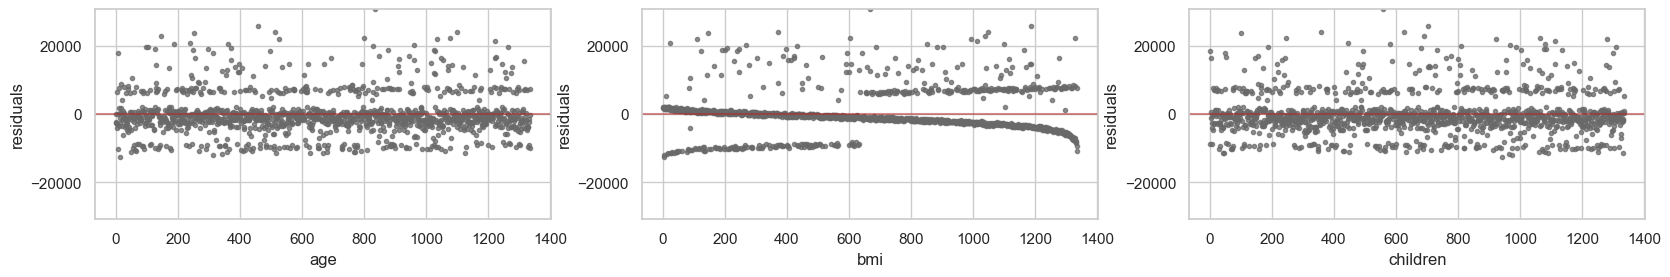

In [29]:
residuals5 = plot_residuals(result5, ["age", "bmi", "children"])

We don't seem to be making much progress here.
There's a non-linearity but we can't identify it. 
Let's switch tactics for a bit and think of *interaction* terms.

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>There's a challenge here. As you add more variables or transform variables, variables you previously eliminated (for example, <tt>male</tt>), might need to be added back in, because it's a <em>new</em> model.</p>
</div>

There are a lot of potential interaction terms: male, age, bmi, smoke_yes, but we only have 1,336 observations so we can't get overly specific. Let's try the big one: male and bmi.

In [30]:
model = "charges ~ age_sq + bmi + male + male:bmi + smoke_yes + children + northwest + southeast + southwest"
result6 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result6)

['Intercept', 'age_sq', 'bmi', 'male', 'male:bmi', 'smoke_yes', 'children', 'northwest', 'southeast', 'southwest']


,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
Intercept,$\beta_{0}$,-7436.11,-10102.41,-4757.62
age_sq,$\beta_{1}$,3.25,2.90,3.53
bmi,$\beta_{2}$,331.93,243.10,414.65
male,$\beta_{3}$,-357.38,-4003.73,2983.29
male:bmi,$\beta_{4}$,7.21,-93.30,129.53
smoke_yes,$\beta_{5}$,23855.81,22939.05,24737.49
children,$\beta_{6}$,613.09,384.72,901.24
northwest,$\beta_{7}$,-365.52,-1167.86,370.77
southeast,$\beta_{8}$,-1033.47,-1929.75,-6.86


Our theory doesn't seem to be borne out by the facts as the $R^2$ didn't even move. Smoking and bmi?

In [13]:
model = "charges ~ age_sq + bmi + smoke_yes + smoke_yes:bmi + children + northwest + southeast + southwest"
result7 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result7)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,2052.06,380.14,3512.02
age_sq,$\beta_{1}$,-20245.97,-24073.65,-16539.77
bmi,$\beta_{2}$,-593.91,-1391.62,292.08
smoke_yes,$\beta_{3}$,-1202.78,-1990.39,-430.27
smoke_yes:bmi,$\beta_{4}$,-1224.93,-1948.21,-496.40
children,$\beta_{5}$,3.34,3.12,3.55
northwest,$\beta_{6}$,19.40,-27.84,65.14
southeast,$\beta_{7}$,1436.36,1319.76,1569.56
southwest,$\beta_{8}$,653.85,478.71,842.20


The $R^2$ went up a lot but what about the *adjusted* $R^2$?

In [14]:
print(models.adjusted_r_squared(result1))
print(models.adjusted_r_squared(result7))

0.7490359662835133
0.8418183004774797


The adjusted $R^2$ increases from 0.75 to 0.84.

What do the residuals look like?

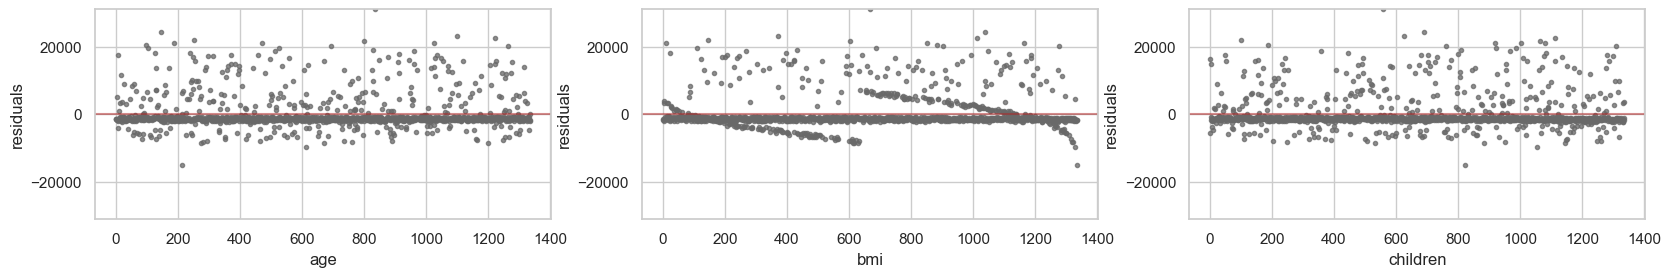

In [33]:
residuals7 = plot_residuals(result7, ["age", "bmi", "children"])

Our error goes down a lot (we can see how tight the data is around 0) but we still have a lot of dispersion and we still have those bands.

Let's look at the actual data. 
First we need to figure out the actual BMI associated with those indices. 
We can do this by replotting with BMI on the axis instead of index:

In [34]:
insurance["residuals"] = residuals7

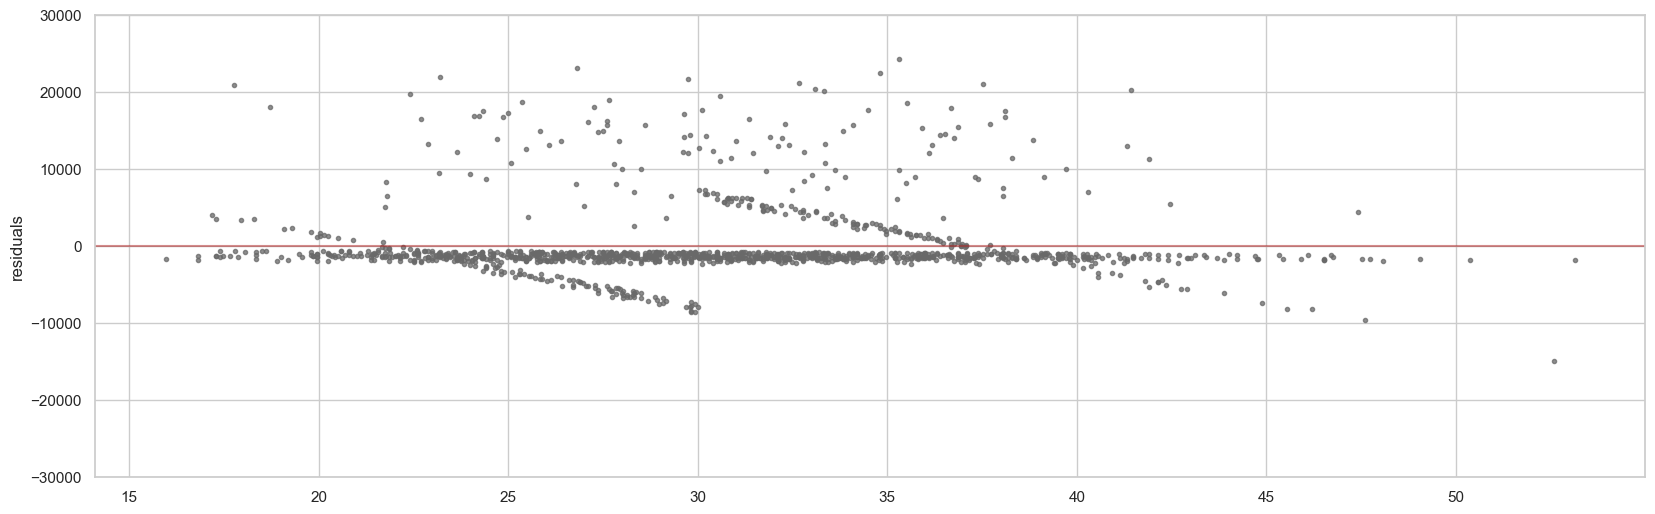

In [35]:
n = result7["n"]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(insurance.bmi.values, insurance.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Notice how we can't see the curvature when plotted as BMI because of overstriking. Still, with this plot, we can see that our problem happens almost exactly at BMI=30. Since we put residuals into the dataframe, we can do a bit of filtering. What happens if we take out women?

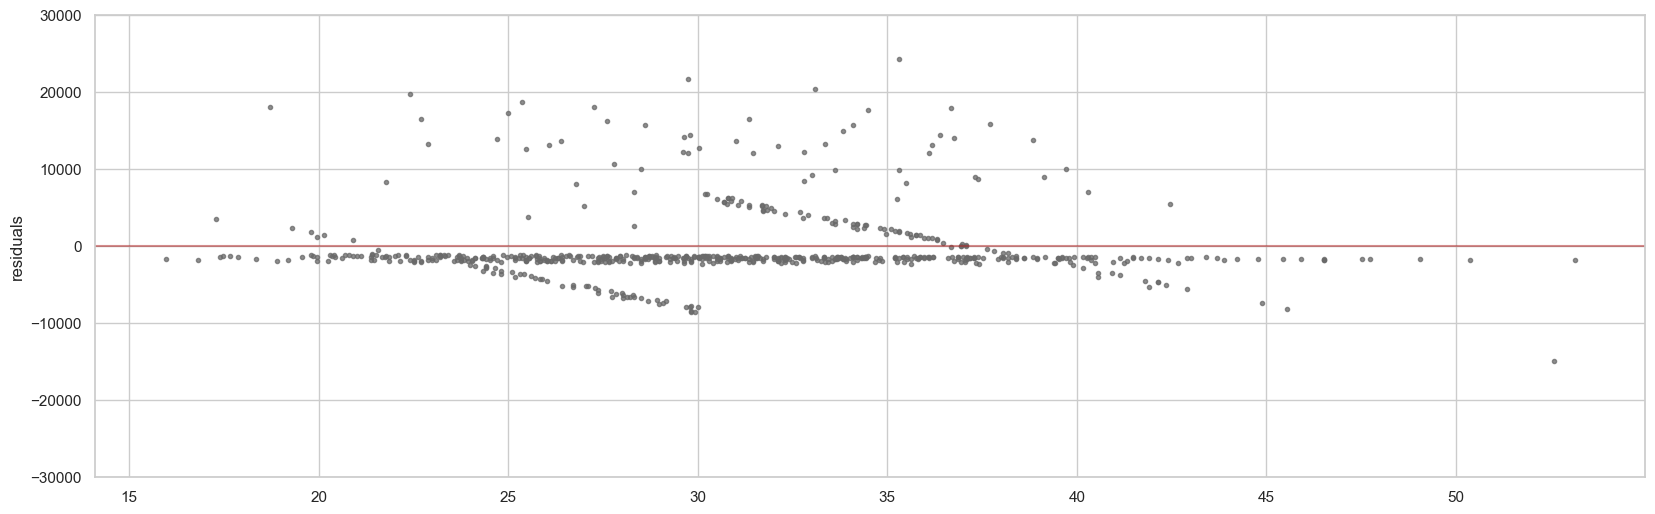

In [36]:
subset = insurance[insurance.male == 1]
n = len(subset.index)

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(subset.bmi.values, subset.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Is it only men?

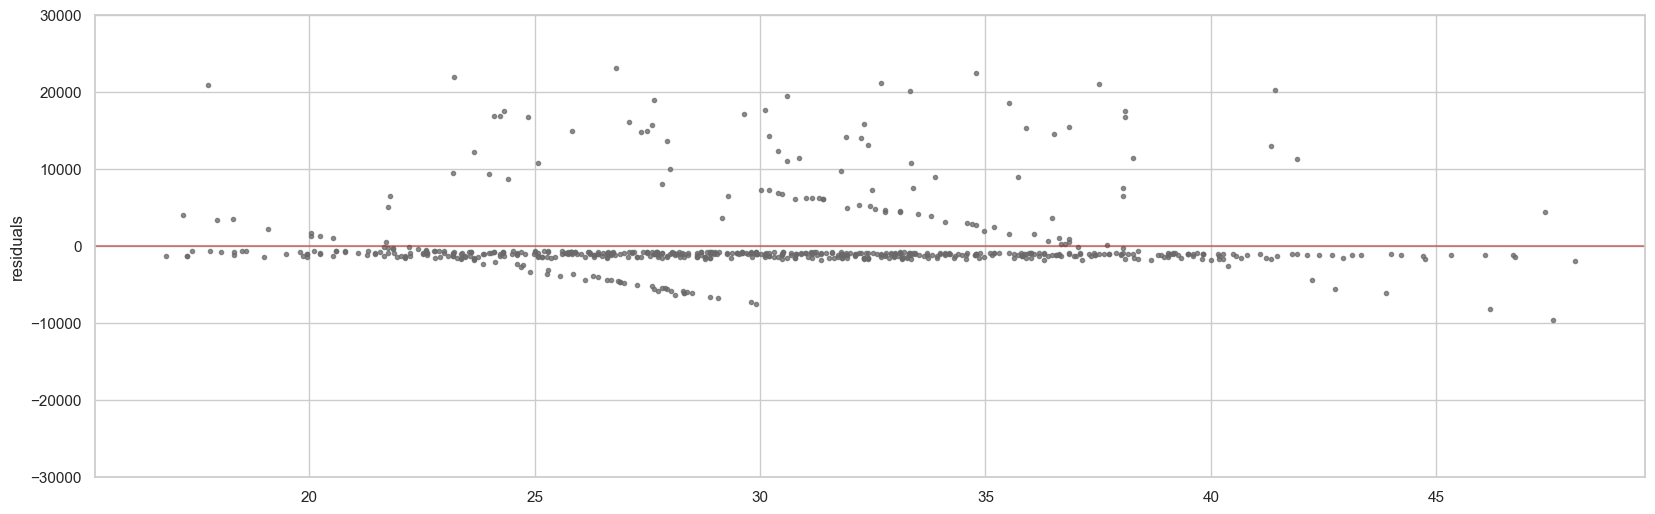

In [37]:
subset = insurance[insurance.male == 0]
n = len(subset.index)

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(subset.bmi.values, subset.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Nope, still there. What about smoking?

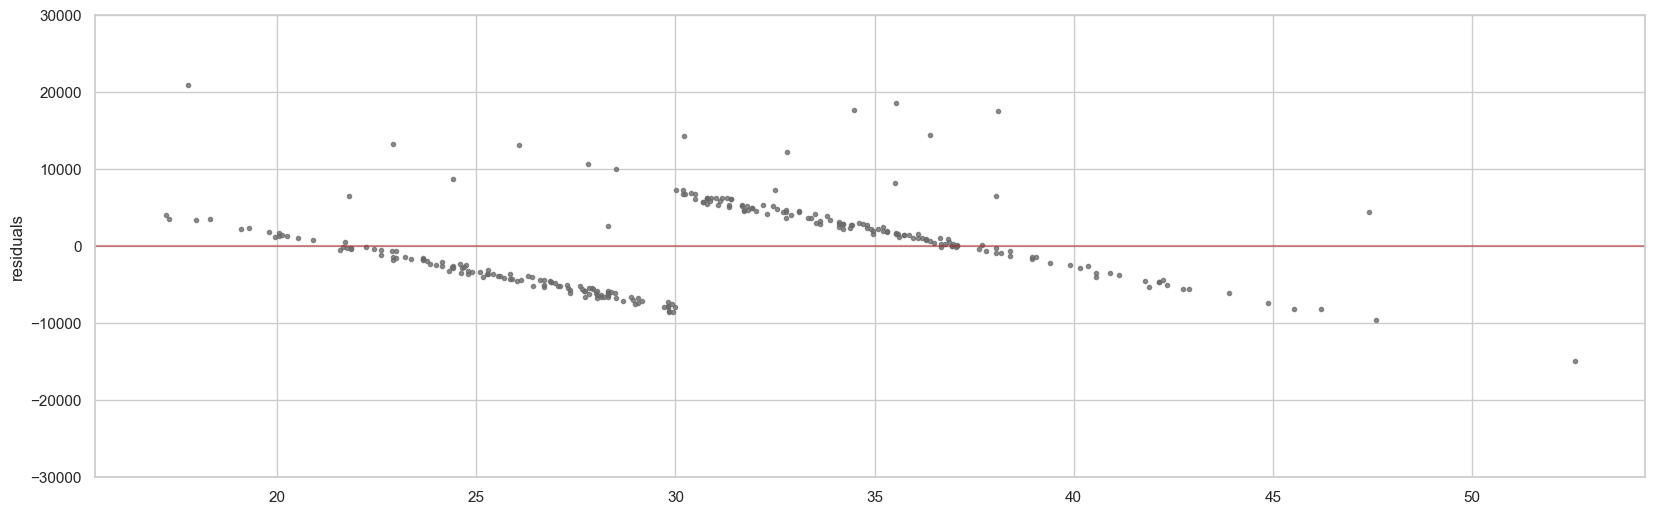

In [38]:
subset = insurance[insurance.smoke_yes == 1]
n = len(subset.index)

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(subset.bmi.values, subset.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Interesting. What about non-smoking?

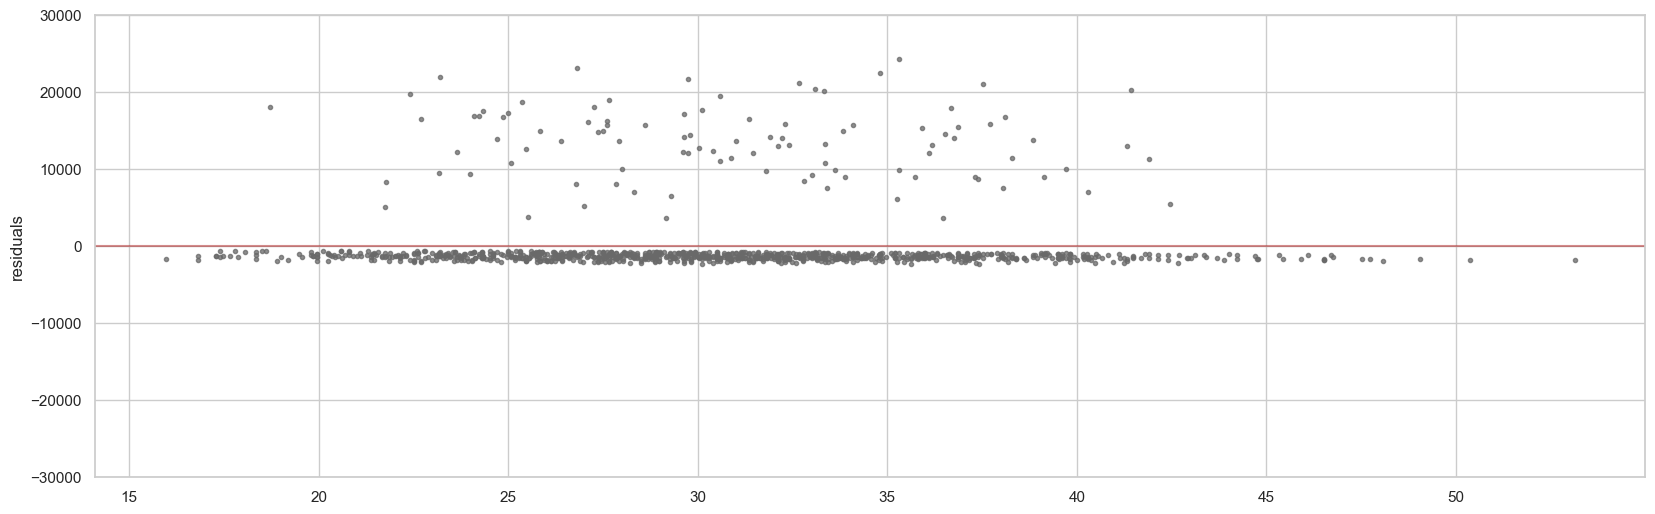

In [39]:
subset = insurance[insurance.smoke_yes == 0]
n = len(subset.index)

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(subset.bmi.values, subset.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Well, there are still problems but not *this* problem. Whatever "this" is, it happens only to smokers, still, it's an incredibly strange discontinuity. Whatever "it" is, we over then underestimate charges until BMI 30...and exactly at BMI 30, it shifts to over estimating and underestimating again.

Could it be as simple as the insurance company is just plain charging more for smokers with a high BMI? Let's create a dummy variable:

In [15]:
insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

In [16]:
model = "charges ~ age_sq + bmi + smoke_yes + smoke_yes:bmi + bmi_above_30 + children + northwest + southeast + southwest"
result9 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result9)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,6642.35,4967.44,8385.87
age_sq,$\beta_{1}$,-20426.54,-23815.87,-17441.08
bmi,$\beta_{2}$,-631.96,-1374.00,159.24
smoke_yes,$\beta_{3}$,-1045.63,-1848.45,-399.75
smoke_yes:bmi,$\beta_{4}$,-1195.76,-1914.69,-588.37
bmi_above_30,$\beta_{5}$,3.33,3.13,3.57
children,$\beta_{6}$,-183.43,-251.02,-118.01
northwest,$\beta_{7}$,1442.38,1338.19,1552.40
southeast,$\beta_{8}$,3026.34,1981.84,3835.47


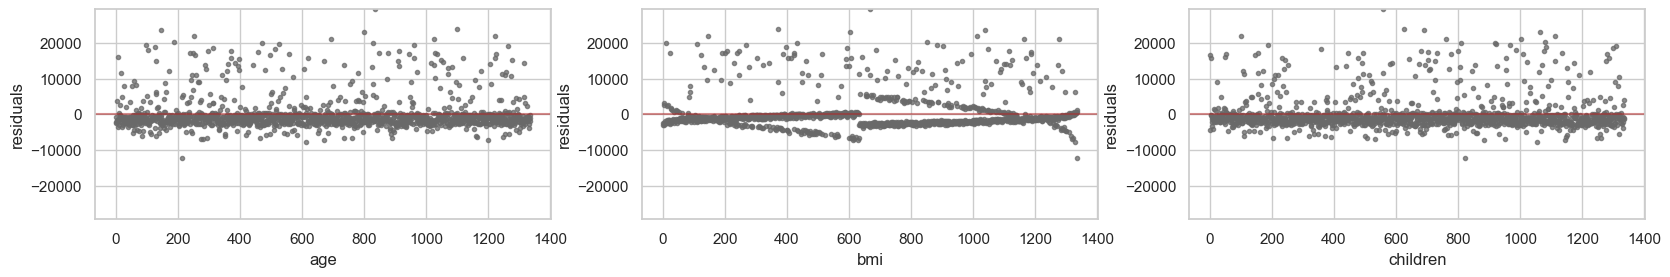

In [42]:
residuals9 = plot_residuals(result9, ["age", "bmi", "children"])

This just breaks up both "bands. We did observe that this only happens to smokers. Let's change this to an interaction term with smoke_yes:

In [17]:
model = "charges ~ age_sq + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + northwest + southeast + southwest"
result10 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result10)

ValueError: 10 columns passed, passed data had 11 columns

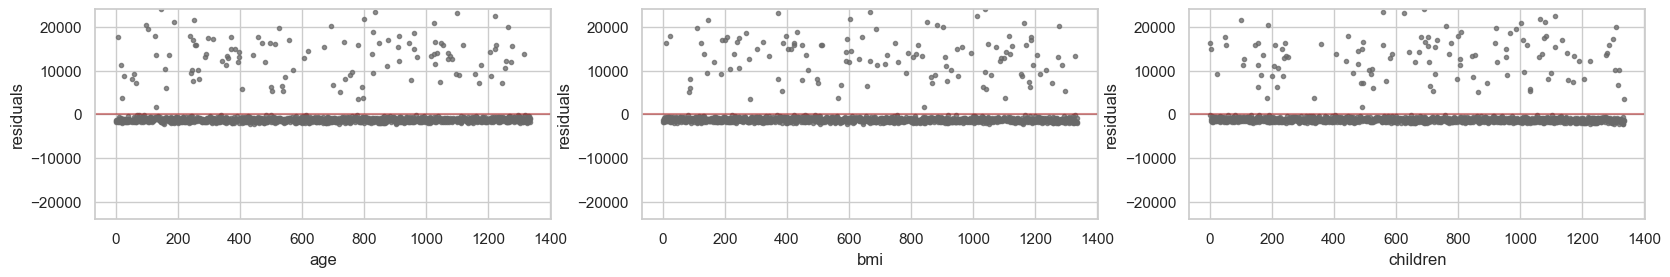

In [44]:
residuals10 = plot_residuals(result10, ["age", "bmi", "children"])

This seems to clear everything up.
Because we have changed the model significantly, we should probably try a model with `male`.

In [45]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + northwest + southeast + southwest"
result11 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result11)

['Intercept', 'age_sq', 'male', 'bmi', 'smoke_yes', 'smoke_yes:bmi', 'smoke_yes:bmi_above_30', 'children', 'northwest', 'southeast', 'southwest']


,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
Intercept,$\beta_{0}$,2259.78,1136.95,3709.36
age_sq,$\beta_{1}$,3.34,3.15,3.54
male,$\beta_{2}$,-520.53,-878.52,-35.40
bmi,$\beta_{3}$,16.33,-22.29,52.92
smoke_yes,$\beta_{4}$,1453.11,-2391.40,4553.24
smoke_yes:bmi,$\beta_{5}$,471.09,350.38,611.80
smoke_yes:bmi_above_30,$\beta_{6}$,15181.03,13709.99,17038.65
children,$\beta_{7}$,655.77,483.91,855.11
northwest,$\beta_{8}$,-380.91,-1012.34,357.61


Interpreting the model, we get...

1. age is positive; this is expected. However, this is $age^2$ so there are increasing returns (each year of age increases charges more than the previous).
2. male is *negative*; if you correct for BMI and smoking, you're not getting charged more for being male.
3. bmi *by itself* doesn't seem to have strong evidence to support it in terms of a score. Maybe charges aren't a good proxy for disease?
4. smoke_yes *by itself* doesn't seem to have a strong effect on charges.
5. smoking_yes *and* bmi have a positive effect on charges.
6. children is positive and has strong support from the data.
7. smoking and a bmi above 30 have a base effect on charges.
8. northeast, by itself, has a negative effect on charges but it is not strongly supported by the data.
9. southeast, by itself, has a negative effect on charges and has good support in the data.
10. southwest, by itself, has a negative effect on charges, and is supported by the data.

Thinking just about smoking and BMI. Neither seems to have a strong effect on *charges* alone. However, together both set a higher base rate of charges and as BMI increases (while smoking) charges increase.

I'm not sure what this says about disease v. charges. 
What about the children? It seems like this would affect women more than men. Let's make it an interaction term:

In [46]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + male:children + smoke_yes:bmi_above_30"
result12 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result12)

['Intercept', 'age_sq', 'male', 'bmi', 'smoke_yes', 'smoke_yes:bmi', 'male:children', 'smoke_yes:bmi_above_30']


,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
Intercept,$\beta_{0}$,2606.58,1592.80,3935.78
age_sq,$\beta_{1}$,3.36,3.16,3.50
male,$\beta_{2}$,-1168.91,-1550.13,-722.30
bmi,$\beta_{3}$,6.58,-38.89,40.73
smoke_yes,$\beta_{4}$,2018.05,-1742.75,6443.64
smoke_yes:bmi,$\beta_{5}$,449.38,282.19,583.51
male:children,$\beta_{6}$,611.63,413.13,896.78
smoke_yes:bmi_above_30,$\beta_{7}$,15327.45,13923.93,17196.53
,,,,


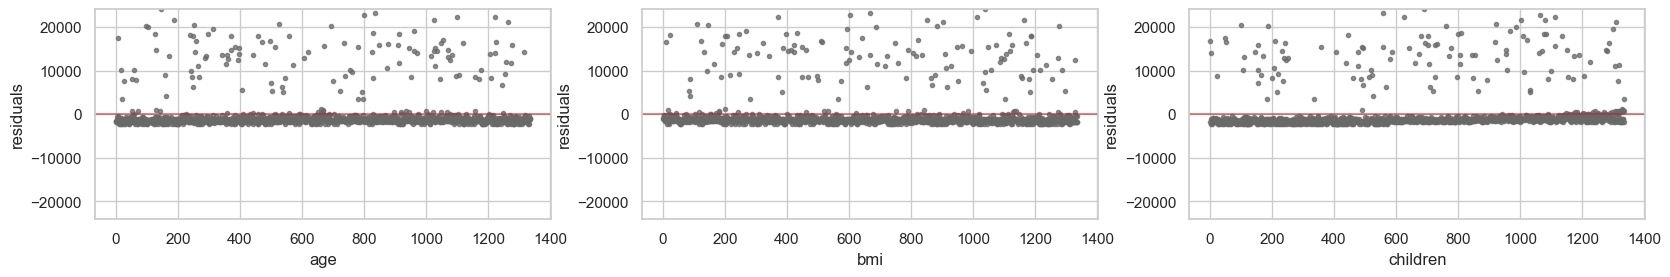

In [47]:
residuals12 = plot_residuals(result12, ["age", "bmi", "children"])

That's strange. The intercept is positive. If you're male, charges go down but if you're a male with *children* charges go back up. We might need both children and the interaction term:

In [48]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result13 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result13)

['Intercept', 'age_sq', 'male', 'bmi', 'smoke_yes', 'smoke_yes:bmi', 'smoke_yes:bmi_above_30', 'children', 'male:children']


,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
Intercept,$\beta_{0}$,1976.96,669.28,2871.51
age_sq,$\beta_{1}$,3.34,3.16,3.54
male,$\beta_{2}$,-423.27,-1026.15,139.48
bmi,$\beta_{3}$,3.32,-24.26,48.43
smoke_yes,$\beta_{4}$,1590.26,-1801.66,5557.10
smoke_yes:bmi,$\beta_{5}$,466.06,310.09,603.64
smoke_yes:bmi_above_30,$\beta_{6}$,15211.86,13808.66,16912.64
children,$\beta_{7}$,695.83,472.57,927.55
male:children,$\beta_{8}$,-85.88,-414.92,211.70


That doesn't seem to help. It looks like having children affects both men's and women's charges. Our "final" model is:

In [49]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children"
final = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(final)

['Intercept', 'age_sq', 'male', 'bmi', 'smoke_yes', 'smoke_yes:bmi', 'smoke_yes:bmi_above_30', 'children']


,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
Intercept,$\beta_{0}$,2014.88,984.21,3271.97
age_sq,$\beta_{1}$,3.34,3.20,3.53
male,$\beta_{2}$,-516.74,-1064.60,-83.94
bmi,$\beta_{3}$,3.56,-30.11,36.26
smoke_yes,$\beta_{4}$,1632.98,-2099.16,6008.72
smoke_yes:bmi,$\beta_{5}$,464.32,303.70,598.88
smoke_yes:bmi_above_30,$\beta_{6}$,15225.57,13691.43,16689.34
children,$\beta_{7}$,651.47,475.46,792.94
,,,,


We know we *can* produce estimates using the Bootstrap but do we *have* to? Looking at the individual residuals, we can see that we do:

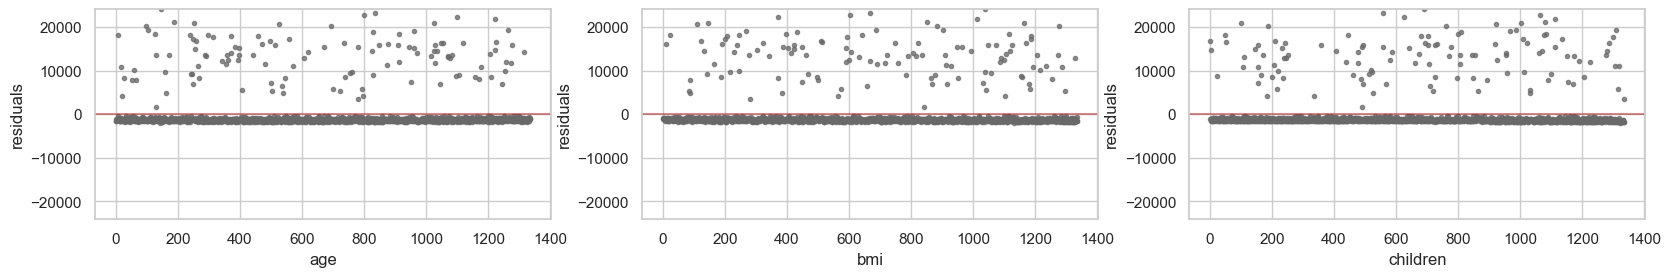

In [50]:
residuals_final= plot_residuals(final, ["age", "bmi", "children"])

These sorts of patterns are typical with targets that can't be negative. There's no place for the other side of the tail to be (or it's just all truncated at "no charges"). Although we didn't do it before, we can also just plot a histogram of residuals:

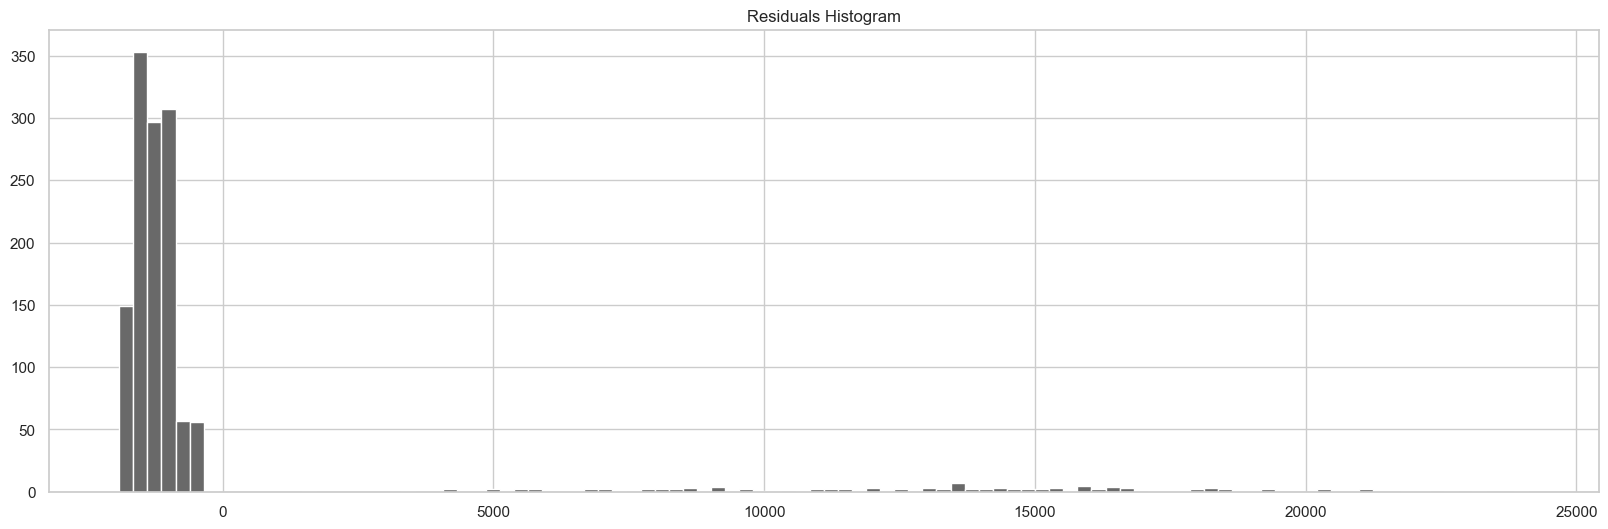

In [51]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(residuals_final, bins=100, color='dimgray')
axes.set_title("Residuals Histogram")
plt.show()
plt.close()

There might be some other analysis we can do but this appears to be the bulk of it. The $R^2$ is pretty high...87%. All the variables in the model make sense. The error of the regression ($\sigma$) is \\$4,378, nearly a 3rd of the Null model's \\$12,110.

I'm not sure what our model turned out to be a model *of*...which goes to validity. You can't use charge data to make a model of disease.

## Prediction

We build models for a purpose.
One of these purposes might be explanation: we want to try to explain charges.
Another purpose is prediction, we might want to predict charges.

Suppose we have a male, 30 years old, who smokes. He's got a BMI of 20.0, which puts him in the ideal range. He has no children.

### Null Model Prediction

If we just look at the Null model, we have a estimated charge of:

In [52]:
insurance.charges.mean()

13270.422265141257

with an error of:

In [53]:
insurance.charges.std()

12110.011236694001

We've already noted that this won't give us sensible error bounds.
The common "solution" is to use a transformation, usually a log transformation.
This is incorrect because $log(E[X]) <> E[log(X)]$.
In words, the log of the expectation of X is not equal to the expectation of the log of X.
Bummer.

We could fit a distributional model here and a log normal distribution seems like a good model.
However, we have a pretty substantial amount of data.
The benefit to using a distributional (mathematical) model is the smoothing over of noisy data.
If you have enough data, the empirical distribution approximates the mathematical model fairly well.
And, if it doesn't, it may better indicate the actual distribution.

In that case, the 95% errors bounds for our prediction are going to be asymptotically well approximated by the 2.5% and 97.5% percentiles of the empirical distribution.

In [54]:
np.percentile(insurance.charges, [2.5, 97.5])

array([ 1631.7332825, 46007.13095  ])

Our predicted charges, based on the Null model, are \\$13,270 with an error bounds of \\$1,631 to \\$46,007 (95%).

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>This might be good enough for some kinds of decision making. Never do anything more complicated than you need to to solve the problem or answer the question at hand. Stick to the CoNVO.</p>
</div>

### Linear Regression Prediction

Let's see how our linear regression model does.
We need a feature vector for Fred:

In [55]:
fred = [1.0, 30**2, 1, 20.0, 1, 20.0, 0, 0]

Remember that because of the way we create a design matrix during training, we need to supply the intercept ($x_0$).
Additionally, we need to calculate all of the interaction terms and perform the transformations "by hand".

Looking at our residuals, we see that they are not symmetric so using the usual plus or minus 1.96 is a bit dodgey.
Instead we'll need to use the Bootstrap get a distribution of predictions.
The Recipe is from the `predictions.ipynb` notebook...

1. generate Bootstrap sample
2. fit a new model
3. calculate residuals
4. make initial prediction
5. sample 1 residual
6. add residual to initial prediction
7. repeat
8. calculate 95% bounds of prediction

In [56]:
import random

In [61]:
predictions = []
for i in range(10_00):
    bootstrap = insurance.sample(len(insurance), replace=True, random_state=342234)
    result = models.linear_regression("charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children", [], bootstrap)
    predict = result["model"].predict([[1.0, 30**2, 1, 20.0, 1, 20.0, 0, 0]])[0][0]
    error = random.choice(result["residuals"])[0]
    obs = predict + error
    predictions.append(obs)

Based on our final model, we can predict the following charges for Fred:

In [62]:
result["model"].predict([[1.0, 30**2, 1, 20.0, 1, 20.0, 0, 0]])[0][0]

15539.45063127881

Our linear regression model predicts charges of \\$15,539 for Fred.
The distribution of predictions based on the Bootstrap is:

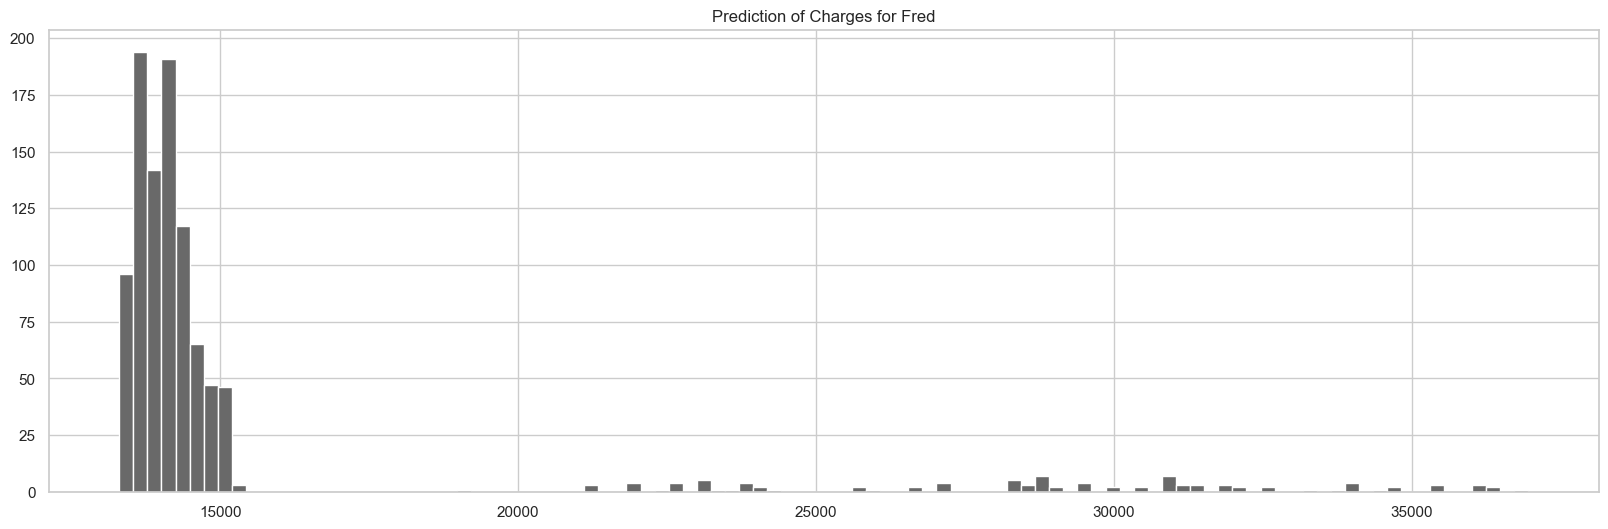

In [63]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(predictions, bins=100, color='dimgray')
axes.set_title("Prediction of Charges for Fred")
plt.show()
plt.close();

And so the 95% error bounds of the prediction is:

In [64]:
np.percentile(predictions, [2.5, 97.5])

array([13437.51185503, 31377.45586114])

The prediction range is thus \\$13,371 to \\$31,367.
This prediction range is much narrower than the original, Null model prediction range of \\$1,631 to \\$46,007 (95%).

Whether it is narrow *enough* depends on the ASK; you may need to talk to your stakeholders.
It might be narrow enough in the aggregate.